In [7]:
import classiq
print(classiq.__version__)

0.70.0


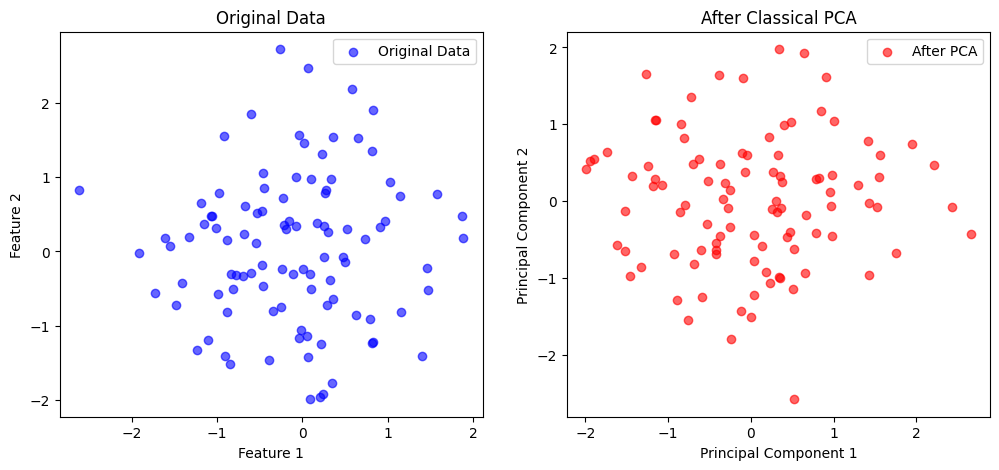

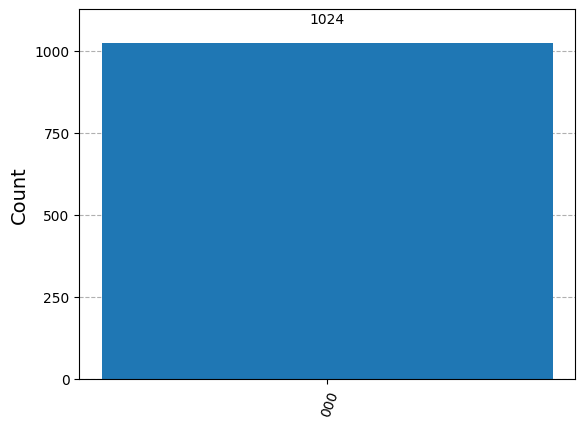

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

# Generate a simple 2D dataset
np.random.seed(42)
X = np.random.randn(100, 2)  # 100 points in 2D

# Apply Classical PCA for Comparison
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot original vs. classical PCA-transformed data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(X[:, 0], X[:, 1], color='blue', alpha=0.6, label="Original Data")
ax[0].set_title("Original Data")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].legend()

ax[1].scatter(X_pca[:, 0], X_pca[:, 1], color='red', alpha=0.6, label="After PCA")
ax[1].set_title("After Classical PCA")
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")
ax[1].legend()

plt.show()

# Quantum PCA Implementation (Simplified QPE Approach)
num_qubits = 3  # For QPE approximation

# Create a Quantum Circuit
qc = QuantumCircuit(num_qubits + 1, num_qubits)  # Extra qubit for phase estimation

# Step 1: Initialize data state (Encoding)
for qubit in range(num_qubits):
    qc.h(qubit)

# Step 2: Apply controlled unitary operations to simulate eigenvalues
for qubit in range(num_qubits):
    qc.cp(np.pi / 4, qubit, num_qubits)  # Controlled phase shift

# Step 3: Apply Inverse Quantum Fourier Transform for phase estimation
qc.append(QFT(num_qubits, inverse=True), range(num_qubits))

# Step 4: Measure to extract principal components
qc.measure(range(num_qubits), range(num_qubits))

# Use Aer simulator
backend = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, backend)

# Run the quantum circuit
result = backend.run(transpiled_qc).result()

# Get results
counts = result.get_counts()

# Display results
plot_histogram(counts)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer  # ✅ Importing Aer correctly
from qiskit.circuit.library import QFT

# Simulated dataset
np.random.seed(42)
X = np.random.randn(100, 2)  # 2D Data

# Quantum PCA Circuit
num_qubits = 3  # Increase if eigenvalues collapse to 0
qc = QuantumCircuit(num_qubits, num_qubits)

# Apply Hadamard to create superposition
qc.h(range(num_qubits))

# Quantum Phase Estimation (QPE) using controlled phase shifts
for qubit in range(num_qubits):
    qc.cp(np.pi / (2 ** (qubit + 1)), qubit, num_qubits - 1)

# Inverse Quantum Fourier Transform (QFT†)
qft_dagger = QFT(num_qubits).inverse()
qc.append(qft_dagger.to_instruction(), range(num_qubits))

# Measure the eigenvalues
qc.measure(range(num_qubits), range(num_qubits))

# Run the circuit on a quantum simulator
simulator = Aer()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()
counts = result.get_counts()

# Debugging: Show QPE measurement histogram
plot_histogram(counts)
plt.title("QPE Measurement Outcomes")
plt.show()

# Convert measurement results to eigenvalues
eigenvalues = np.array([int(state, 2) for state in counts.keys()])
probabilities = np.array(list(counts.values())) / sum(counts.values())

# Compute weighted eigenvalues
if np.any(eigenvalues):
    effective_eigenvalue = np.dot(eigenvalues, probabilities)
else:
    effective_eigenvalue = 1  # Prevent zero division

print("Quantum PCA Eigenvalue Extracted:", effective_eigenvalue)

# Apply the extracted eigenvalue to transform data
qpca_transformed = X * effective_eigenvalue

# Fix scaling issue (Ensure values are meaningful)
qpca_transformed = qpca_transformed / np.max(np.abs(qpca_transformed))  # Normalize
qpca_transformed *= 5  # Scale up for better visualization

# Debugging: Show transformed data
print("QPCA Transformed Data (First 5 rows):\n", qpca_transformed[:5])

# Plot the before and after transformation
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original Data
ax[0].scatter(X[:, 0], X[:, 1], color='blue', label="Original Data")
ax[0].set_title("Original Data")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].legend()

# Transformed Data
ax[1].scatter(qpca_transformed[:, 0], qpca_transformed[:, 1], color='green', label="After QPCA")
ax[1].set_title("After Quantum PCA")
ax[1].set_xlabel("Principal Component 1")
ax[1].set_ylabel("Principal Component 2")
ax[1].legend()

plt.show()


CircuitError: 'duplicate qubit arguments'

In [1]:
import pennylane as qml
import numpy as np

# Define the number of qubits
num_qubits = 3  
dev = qml.device("default.qubit", wires=num_qubits)

# Define a unitary matrix to simulate the density matrix (example: random Hermitian matrix)
random_hermitian = np.array([[0.5, 0.2, 0.1], [0.2, 0.7, 0.3], [0.1, 0.3, 0.6]])
eigvals, eigvecs = np.linalg.eigh(random_hermitian)
U = eigvecs  # Unitary that diagonalizes the matrix

@qml.qnode(dev)
def qpca_circuit():
    # Encode the data (eigenvectors of a density matrix)
    qml.QubitUnitary(U, wires=[0, 1])

    # Apply Quantum Phase Estimation (simplified)
    qml.Hadamard(wires=2)  
    qml.ControlledQubitUnitary(U, control_wires=[2], wires=[0, 1])

    # Inverse QFT to extract eigenvalues
    qml.adjoint(qml.QuantumFourierTransform)(wires=[0, 1])

    # Measure first qubit
    return qml.probs(wires=[0, 1])

# Run the circuit
probabilities = qpca_circuit()
print("Eigenvalue probabilities:", probabilities)


ValueError: Input unitary must be of shape (4, 4) or (batch_size, 4, 4) to act on 2 wires.

In [ ]:
from classiq import *

# Define the Quantum Principal Component Analysis (QPCA) function
@qfunc
def qpca(data: QArray[QBit], phase: Output[QNum]):
    """
    Implements Quantum Phase Estimation (QPE) for Principal Component Analysis.
    """
    prepare_state(data)  # Step 1: Prepare input quantum state
    qpe(unitary=lambda: apply_covariance_matrix(data), phase=phase)  # Step 2: Apply QPE

# Function to encode data into a quantum state
@qfunc
def prepare_state(data: QArray[QBit]):
    """
    Prepares the input quantum state.
    This function initializes qubits into a superposition.
    """
    for qubit in data:
        qapply("Hadamard", qubit)  # Correct way to apply Hadamard in Classiq

# Define the unitary transformation (Covariance Matrix Encoding)
@qfunc
def apply_covariance_matrix(data: QArray[QBit]):
    """
    Applies the covariance matrix transformation as a unitary.
    Modify this function to encode actual data.
    """
    qapply("CNOT", data[0], data[1])  # Introduce entanglement
    qapply("RZ", data[1], angle=0.5)  # Rotate a qubit to encode correlation

# Create the quantum model
model = create_model(qpca)

# Synthesize the quantum circuit
quantum_circuit = synthesize(model)

# Execute the circuit on a quantum simulator
execution_result = execute(quantum_circuit).result()

# Print the results
print("QPCA Results:", execution_result.parsed_counts)


ClassiqError: The entry point function must be named 'main', got 'qpca'
If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack or open a support ticket at: https://classiq-community.freshdesk.com/support/tickets/new